In [ ]:
import pandas as pd

# Load the true news data
true_file_path = 'News _dataset\True.csv'
true_data = pd.read_csv(true_file_path)

# Load the fake news data
fake_file_path = 'News _dataset\Fake.csv'
fake_data = pd.read_csv(fake_file_path)

# Display the first few rows of the data
print(true_data.head())
print(fake_data.head())


In [ ]:
# Add label for true news
true_data['label'] = 1

# Add label for fake news
fake_data['label'] = 0

# Combine the datasets
data = pd.concat([true_data, fake_data], ignore_index=True)

# Check the combined data
print(data.head())
print(data.tail())


In [5]:
import re

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = re.sub(r'\d', ' ', text)  # Remove digits
    text = text.lower()  # Convert to lowercase
    return text

data['text'] = data['text'].apply(preprocess_text)


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Split the data into features and labels
X = data['text']
y = data['label']

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(X)


In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

# Stratified splitting to ensure both classes are represented proportionally
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


In [8]:
from sklearn.linear_model import LogisticRegression

# Train the model
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [9]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(classification_rep)


Accuracy: 0.9860801781737194
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [10]:
import joblib

# Save the model
joblib.dump(model, 'fake_news_detection_model.joblib')

# Save the vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')


['tfidf_vectorizer.joblib']

Model Evaluation

In [16]:
# Load the new dataset
new_data = pd.read_csv('News _dataset\Test.csv')

# Preprocess the new data
new_data['text'] = new_data['text'].apply(preprocess_text)

# Transform the text using the saved vectorizer
X_new = vectorizer.transform(new_data['text'])

# Make predictions
new_predictions = model.predict(X_new)

# Evaluate the predictions (if you have true labels for the new data)
new_labels = new_data['Label']  # if you have true labels
new_accuracy = accuracy_score(new_labels, new_predictions)
new_classification_rep = classification_report(new_labels, new_predictions)

print(f"New Data Accuracy: {new_accuracy}")
print(new_classification_rep)


New Data Accuracy: 0.9977477477477478
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        41
           1       1.00      1.00      1.00       403

    accuracy                           1.00       444
   macro avg       0.99      1.00      0.99       444
weighted avg       1.00      1.00      1.00       444



Check for the overfitting

In [17]:
# Training accuracy
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

# Test accuracy
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")


Training Accuracy: 0.9896430758950944
Test Accuracy: 0.9860801781737194


In [18]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean()}")


Cross-Validation Scores: [0.98073497 0.97928731 0.9642539  0.97115492 0.97917363]
Mean Cross-Validation Score: 0.9749209427292735


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
}

# Instantiate the grid search
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Evaluate the model again
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")


Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Training Accuracy: 0.9990533994097667
Test Accuracy: 0.9935412026726058


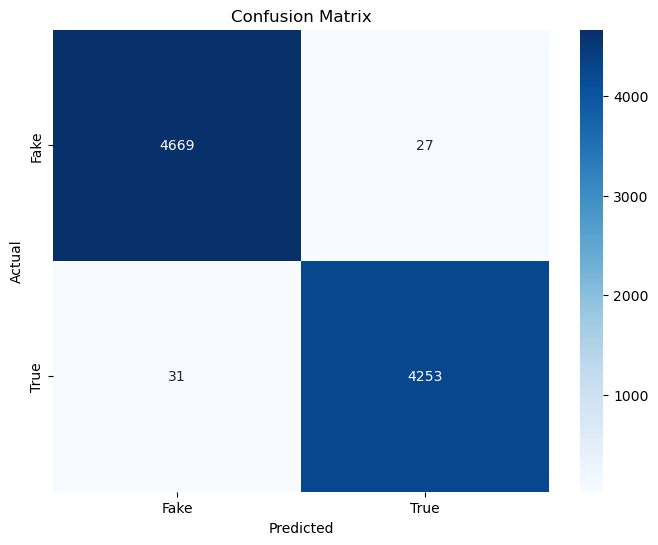

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [23]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(y_test, y_test_pred)
print(class_report)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
pip install shap


c:\Users\smadh\anaconda3\Lib\site-packages\shap\explainers\_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


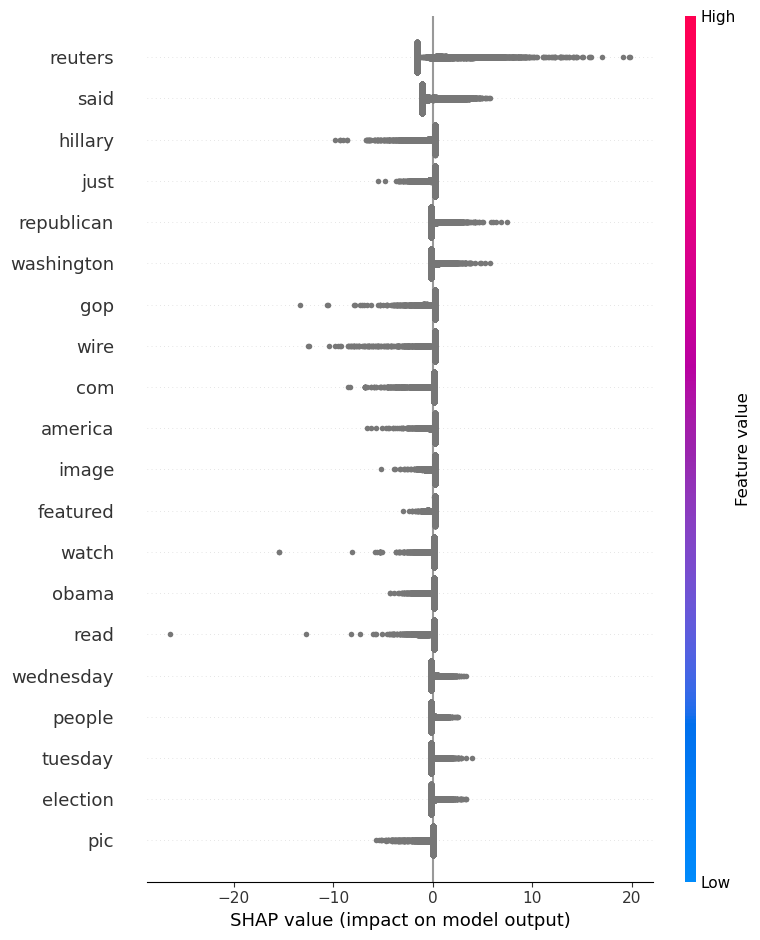

In [27]:
import shap

# Create a SHAP explainer
explainer = shap.LinearExplainer(best_model, X_train, feature_perturbation="interventional")

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot the SHAP values
shap.summary_plot(shap_values, X_test, feature_names=vectorizer.get_feature_names_out())
